<a href="https://colab.research.google.com/github/sidd-2203/Intrusion-Detection/blob/main/E_GraphSAGE_NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
install_command = "pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html"

In [3]:
!{sys.executable} -m {install_command}

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.5/467.5 MB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166

In [4]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# data = pd.read_csv('/content/drive/MyDrive/EGraph SAGE/UNSW_2018_IoT_Botnet_Full5pc_4.csv')

In [7]:
train_file_path='https://raw.githubusercontent.com/sidd-2203/Intrusion-Detection/main/csv_result-KDDTrain%2B.csv'
test_file_path='https://raw.githubusercontent.com/sidd-2203/Intrusion-Detection/main/KDDTest.csv'

data=pd.read_csv(train_file_path)
data=data.drop(['id'],axis=1)
test_data=pd.read_csv(test_file_path,header=None,names=data.columns)
data=pd.concat([data,test_data],axis=0)
print('Dimensions of the Training set:',data.shape)
# print('Dimensions of the Test set:',test_data.shape)

Dimensions of the Training set: (148517, 42)


In [8]:
data.head(200)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,tcp,http,SF,271,4781,0,0,0,0,...,28,1.00,0.00,0.09,0.25,0.00,0.00,0.00,0.00,normal
196,0,tcp,ftp_data,SF,14416,0,0,0,0,0,...,50,0.19,0.02,0.19,0.04,0.00,0.00,0.00,0.00,normal
197,0,tcp,http,SF,227,11564,0,0,0,0,...,52,1.00,0.00,0.02,0.04,0.00,0.00,0.00,0.00,normal
198,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.52,1.00,0.00,0.00,0.00,1.00,1.00,anomaly


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148517 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13  root_

In [10]:
object_cols=['protocol_type','flag']

In [11]:
data=pd.get_dummies(data,columns=object_cols,dtype=float)

In [12]:
data.head(10)

,duration,service,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,ftp_data,491,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,other,146,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,private,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,http,232,8153,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,http,199,420,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0,private,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,private,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0,private,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0,remote_job,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0,private,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#removed all the object type attributes kept only the int or float type
data.drop(columns=['service'],inplace=True)

In [14]:
data.rename(columns={"class": "label"},inplace = True)

In [15]:
data['label'].replace({'normal':0,'anomaly':1},inplace=True)

In [16]:
data.label.value_counts()

label
0    77054
1    71463
Name: count, dtype: int64

In [17]:
import socket
import struct
import random

In [18]:
#These hexadecimal values correspond to IP addresses in the private IPv4 address range (172.16.0.1 to 172.16.255.255).
#socket.inet_ntoa(...): Converts the packed binary string back to an IPv4 address in dotted-decimal notation (e.g., ‘192.168.0.1’).
data['saddr'] = [socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac10ffff))) for _ in range(len(data))]

In [19]:
data['daddr'] = [socket.inet_ntoa(struct.pack('>I', random.randint(0xc0a80001, 0xc0a8ffff))) for _ in range(len(data))]

In [20]:
data.head(20)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,saddr,daddr
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.227.123,192.168.37.141
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.170.86,192.168.7.135
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.71.103,192.168.172.14
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.3.105,192.168.191.3
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.130.76,192.168.175.110
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.16.101.23,192.168.215.75
6,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.71.16,192.168.33.15
7,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.29.80,192.168.190.77
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.114.89,192.168.56.6
9,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.117.215,192.168.161.164


In [21]:
len(data['saddr'].unique())

58655

In [22]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [23]:
data.head(10)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,saddr,daddr
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.227.123,192.168.37.141
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.170.86,192.168.7.135
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.71.103,192.168.172.14
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.3.105,192.168.191.3
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.130.76,192.168.175.110
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172.16.101.23,192.168.215.75
6,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.71.16,192.168.33.15
7,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.29.80,192.168.190.77
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.114.89,192.168.56.6
9,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.117.215,192.168.161.164


In [24]:
label_ground_truth.head(10)

,saddr,daddr,label
0,172.16.227.123,192.168.37.141,0
1,172.16.170.86,192.168.7.135,0
2,172.16.71.103,192.168.172.14,1
3,172.16.3.105,192.168.191.3,0
4,172.16.130.76,192.168.175.110,0
5,172.16.101.23,192.168.215.75,1
6,172.16.71.16,192.168.33.15,1
7,172.16.29.80,192.168.190.77,1
8,172.16.114.89,192.168.56.6,1
9,172.16.117.215,192.168.161.164,1


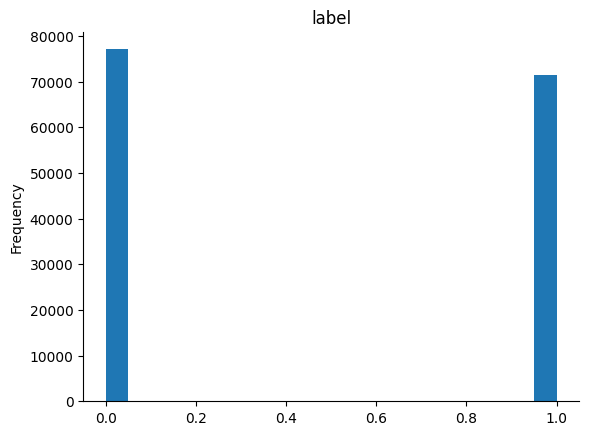

In [25]:
# @title label

from matplotlib import pyplot as plt
label_ground_truth['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [26]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [27]:
data.fillna(0,inplace = True)

In [28]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [29]:
data.drop(columns=['index'],inplace=True)

In [30]:
data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,saddr,daddr
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.227.123,192.168.37.141
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.170.86,192.168.7.135
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,172.16.71.103,192.168.172.14
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.3.105,192.168.191.3
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.130.76,192.168.175.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,794,333,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.48.5,192.168.175.155
148513,0,317,938,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.187.220,192.168.87.104
148514,0,54540,8314,0,0,0,2,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.253.55,192.168.228.149
148515,0,42,42,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,172.16.223.223,192.168.183.31


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   src_bytes                    148517 non-null  int64  
 2   dst_bytes                    148517 non-null  int64  
 3   land                         148517 non-null  int64  
 4   wrong_fragment               148517 non-null  int64  
 5   urgent                       148517 non-null  int64  
 6   hot                          148517 non-null  int64  
 7   num_failed_logins            148517 non-null  int64  
 8   logged_in                    148517 non-null  int64  
 9   num_compromised              148517 non-null  int64  
 10  root_shell                   148517 non-null  int64  
 11  su_attempted                 148517 non-null  int64  
 12  num_root                     148517 non-null  int64  
 13 

In [32]:
scaler = StandardScaler()
cols_to_norm = list(set(data.columns)-set(['label','saddr','daddr']))
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [33]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,...,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05,1.485170e+05
mean,-5.501890e-18,-1.722331e-18,-7.176378e-19,6.650110e-18,-1.918485e-17,-1.674488e-19,8.611653e-18,-1.071672e-17,-1.063061e-16,-1.578803e-18,...,-3.636031e-17,-3.980498e-17,-1.267827e-17,9.090079e-18,6.583131e-17,1.071672e-17,-1.751036e-17,-1.607509e-17,-1.326195e-16,1.925661e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.124811e-01,-7.436409e-03,-4.614229e-03,-1.468026e-02,-8.548778e-02,-1.040310e-02,-9.407084e-02,-5.983194e-02,-8.212489e-01,-1.147309e-02,...,-3.362100e-01,-1.263853e-01,-2.659868e-02,-1.457662e-01,-5.746005e-01,-5.104705e-02,-3.093597e-02,-4.483903e-02,-1.237025e+00,-4.818309e-02
25%,-1.124811e-01,-7.436409e-03,-4.614229e-03,-1.468026e-02,-8.548778e-02,-1.040310e-02,-9.407084e-02,-5.983194e-02,-8.212489e-01,-1.147309e-02,...,-3.362100e-01,-1.263853e-01,-2.659868e-02,-1.457662e-01,-5.746005e-01,-5.104705e-02,-3.093597e-02,-4.483903e-02,-1.237025e+00,-4.818309e-02
50%,-1.124811e-01,-7.428275e-03,-4.614229e-03,-1.468026e-02,-8.548778e-02,-1.040310e-02,-9.407084e-02,-5.983194e-02,-8.212489e-01,-1.147309e-02,...,-3.362100e-01,-1.263853e-01,-2.659868e-02,-1.457662e-01,-5.746005e-01,-5.104705e-02,-3.093597e-02,-4.483903e-02,8.083909e-01,-4.818309e-02
75%,-1.124811e-01,-7.385019e-03,-4.460051e-03,-1.468026e-02,-8.548778e-02,-1.040310e-02,-9.407084e-02,-5.983194e-02,1.217658e+00,-1.147309e-02,...,-3.362100e-01,-1.263853e-01,-2.659868e-02,-1.457662e-01,-5.746005e-01,-5.104705e-02,-3.093597e-02,-4.483903e-02,8.083909e-01,-4.818309e-02
max,2.334247e+01,2.550882e+02,3.536968e+02,6.811869e+01,1.241096e+01,1.544933e+02,5.007598e+01,6.914625e+01,1.217658e+00,3.364061e+02,...,2.974332e+00,7.912314e+00,3.759585e+01,6.860303e+00,1.740339e+00,1.958977e+01,3.232483e+01,2.230200e+01,8.083909e-01,2.075417e+01


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [35]:
X_train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,saddr,daddr
939,-0.112481,-0.007388,-0.004538,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.40.182,192.168.231.229
35399,-0.112481,-0.007382,-0.003255,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.186.246,192.168.242.136
86613,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.95.107,192.168.219.0
81333,-0.112481,-0.007382,-0.004278,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.137.123,192.168.150.172
74256,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.131.209,192.168.244.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81216,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.198.20,192.168.218.3
95657,-0.112481,-0.007428,-0.004594,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.208.40,192.168.160.33
42127,-0.112481,-0.007429,-0.004595,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.133.166,192.168.94.83
53820,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.60.115,192.168.230.69


In [36]:
X_test

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,saddr,daddr
134846,-0.112481,-0.007398,-0.002464,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.165.100,192.168.201.81
4365,-0.112481,-0.007391,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.82.170,192.168.123.160
20592,-0.112481,-0.007435,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.148.84,192.168.236.77
125065,-0.112481,-0.007413,-0.004566,-0.01468,-0.085488,-0.010403,0.402662,13.781384,-0.821249,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.241.182,192.168.138.244
81125,-0.112481,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,-0.821249,-0.011473,...,-0.026599,-0.145766,1.740339,-0.051047,-0.030936,-0.044839,-1.237025,-0.048183,172.16.232.11,192.168.88.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26657,-0.112481,-0.007357,-0.003896,-0.01468,-0.085488,-0.010403,-0.094071,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.218.97,192.168.38.192
142826,-0.112481,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,-0.059832,1.217658,0.033509,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.67.120,192.168.156.59
31509,-0.112481,-0.007406,-0.004614,-0.01468,-0.085488,-0.010403,0.899396,-0.059832,1.217658,-0.011473,...,-0.026599,-0.145766,-0.574601,-0.051047,32.324826,-0.044839,-1.237025,-0.048183,172.16.41.135,192.168.37.185
58242,-0.109230,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,-0.059832,1.217658,0.033509,...,-0.026599,-0.145766,-0.574601,-0.051047,-0.030936,-0.044839,0.808391,-0.048183,172.16.82.72,192.168.174.221


In [37]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [38]:
X_train['h']

939       [-0.2806495158011896, -0.023312592701421605, -...
35399     [-0.09712072297724839, -0.023312592701421605, ...
86613     [-0.2806495158011896, -0.023312592701421605, -...
81333     [-0.2806495158011896, -0.023312592701421605, -...
74256     [-0.2806495158011896, -0.023312592701421605, -...
                                ...                        
81216     [-0.2806495158011896, -0.023312592701421605, -...
95657     [-0.2806495158011896, -0.023312592701421605, -...
42127     [-0.2806495158011896, -0.023312592701421605, -...
53820     [-0.2806495158011896, -0.023312592701421605, -...
138359    [-0.09712072297724839, -0.023312592701421605, ...
Name: h, Length: 103961, dtype: object

In [39]:
#from dgl.data.utils import load_graphs
#G = load_graphs("./data.bin")[0][0]

In [40]:
X_train.daddr.describe()

count            103961
unique            52230
top       192.168.38.28
freq                  9
Name: daddr, dtype: object

In [41]:
X_train.saddr.describe()

count            103961
unique            52045
top       172.16.27.240
freq                 10
Name: saddr, dtype: object

In [42]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [43]:
G = G.to_directed()

In [44]:
G = from_networkx(G,edge_attrs=['h','label'])

In [45]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [46]:
G.edata['h'].shape[1]

52

In [47]:
G.num_nodes()

104275

In [48]:
th.ones(G.num_nodes(), G.edata['h'].shape[1])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [49]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [50]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [51]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [52]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [53]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        global score
        global emb
        emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [54]:
G.ndata['h'].shape

torch.Size([104275, 1, 52])

In [55]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [56]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 256, activation))
        self.layers.append(SAGELayer(256, edim, 256, activation))
        self.layers.append(SAGELayer(256, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [57]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [58]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(G.edata['label'].cpu().numpy()),y=G.edata['label'].cpu().numpy())

In [59]:
class_weights

array([0.9637262 , 1.03911123])

In [60]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [61]:
criterion

CrossEntropyLoss()

In [62]:
G = G.to('cuda:0')

In [63]:
G.device

device(type='cuda', index=0)

In [64]:
G.ndata['h'].device

device(type='cuda', index=0)

In [65]:
G.edata['h'].device

device(type='cuda', index=0)

In [66]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,1500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 50  Training acc: 0.9084175825119019
Epoch: 100  Training acc: 0.9279104471206665
Epoch: 150  Training acc: 0.9441280364990234
Epoch: 200  Training acc: 0.9501399397850037
Epoch: 250  Training acc: 0.9532949328422546
Epoch: 300  Training acc: 0.9564499855041504
Epoch: 350  Training acc: 0.9586479067802429
Epoch: 400  Training acc: 0.9619231820106506
Epoch: 450  Training acc: 0.9634333848953247
Epoch: 500  Training acc: 0.9624282121658325
Epoch: 550  Training acc: 0.9666509032249451
Epoch: 600  Training acc: 0.9665595293045044
Epoch: 650  Training acc: 0.9696232080459595
Epoch: 700  Training acc: 0.9708688855171204
Epoch: 750  Training acc: 0.9726147055625916
Epoch: 800  Training acc: 0.9729032516479492
Epoch: 850  Training acc: 0.9741970300674438
Epoch: 900  Training acc: 0.9765440821647644
Epoch: 950  Training acc: 0.9753272533416748
Epoch: 1000  Training acc: 0.9773520827293396
Epoch: 1050  Training acc: 0.9767124056816101
Epoch: 1100  Training acc: 0.9804301261901855
Epoch: 1

In [67]:
#model.load_state_dict(th.load('bot_binary.pt'))
#model.eval()

In [68]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [69]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), len(cols_to_norm))

In [70]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [71]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [72]:
G_test = G_test.to('cuda:0')

In [73]:
th.cuda.empty_cache()

In [74]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [75]:
print(str(elapsed) + ' seconds')

0.032678347999990365 seconds


In [76]:
test_pred = test_pred.argmax(1)

In [77]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [78]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [79]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

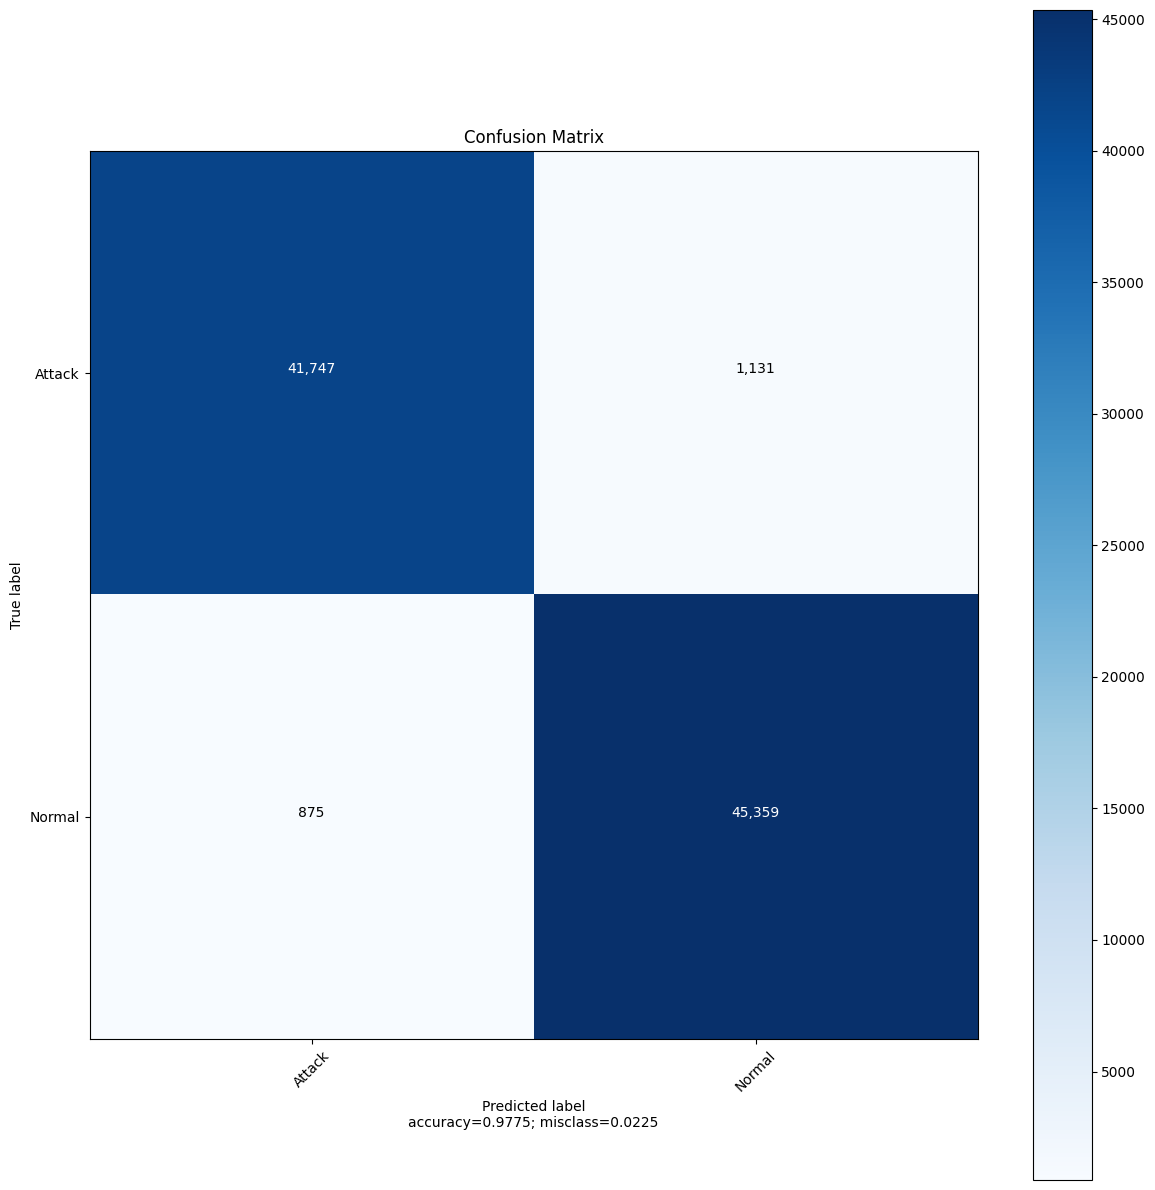

In [80]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [81]:
from sklearn.metrics import classification_report
target_names = np.unique(actual)
print(classification_report(actual, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Attack     0.9795    0.9736    0.9765     42878
      Normal     0.9757    0.9811    0.9784     46234

    accuracy                         0.9775     89112
   macro avg     0.9776    0.9773    0.9775     89112
weighted avg     0.9775    0.9775    0.9775     89112



In [82]:
emb

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0681,  0.7912,  0.3633],
        [ 1.0027,  0.7837,  0.9042,  ...,  3.8816,  0.0000,  1.8139],
        [ 1.0027,  0.7837,  0.9042,  ...,  2.8707,  0.0000,  1.6243],
        ...,
        [ 6.0348,  3.9334,  5.6731,  ...,  0.0000,  6.7888,  0.0000],
        [15.7168, 10.1947, 11.2481,  ...,  4.8039,  4.6538,  3.6294],
        [ 4.2772,  2.9175,  2.7805,  ...,  0.0000,  0.7272,  0.6761]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [83]:
emb_num = emb.cpu().detach().numpy()


In [84]:
np.save('emb_bin.npy',emb_num)